In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In this notebook a Generative Adversarial Network (GAN) is built and trained to generate random cat images.


1.   In part A, you can find the process of building and training the GAN.
2.   In part B, you can download the trained model and generate random cat images.





### Import packages

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
import os
from os import walk
import time
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:

print(tf.__version__)
device_name = tf.test.gpu_device_name()
print(device_name)

2.8.0
/device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# A. Building and training the Generative Adversarial Network (GAN).

### Preparing data

In [5]:
data_dir = "data"

In [6]:
!unzip /content/gdrive/My\ Drive/projects/image_generator/data/cats_dataset.zip -d data
!rm -r data/cats

Streaming output truncated to the last 5000 lines.
  inflating: data/cats/CAT_05/00001130_020.jpg  
  inflating: data/cats/CAT_05/00001130_020.jpg.cat  
  inflating: data/cats/CAT_05/00001130_023.jpg  
  inflating: data/cats/CAT_05/00001130_023.jpg.cat  
  inflating: data/cats/CAT_05/00001130_026.jpg  
  inflating: data/cats/CAT_05/00001130_026.jpg.cat  
  inflating: data/cats/CAT_05/00001131_003.jpg  
  inflating: data/cats/CAT_05/00001131_003.jpg.cat  
  inflating: data/cats/CAT_05/00001131_026.jpg  
  inflating: data/cats/CAT_05/00001131_026.jpg.cat  
  inflating: data/cats/CAT_05/00001132_007.jpg  
  inflating: data/cats/CAT_05/00001132_007.jpg.cat  
  inflating: data/cats/CAT_05/00001132_008.jpg  
  inflating: data/cats/CAT_05/00001132_008.jpg.cat  
  inflating: data/cats/CAT_05/00001132_014.jpg  
  inflating: data/cats/CAT_05/00001132_014.jpg.cat  
  inflating: data/cats/CAT_05/00001132_017.jpg  
  inflating: data/cats/CAT_05/00001132_017.jpg.cat  
  inflating: data/cats/CAT_05/0

In [7]:
image_width = 128
image_height = 128
num_channels = 3
latent_dim = 128
batch_size = 20


### Prepare DataGenerator

In [8]:
class DataGenerator(keras.utils.Sequence):
    # initialization
    def __init__(self, image_files_path, batch_size=8, shuffle=True, dim=(image_width,image_height,num_channels)):
        self.dim = dim
        self.batch_size = batch_size
        self.image_files_path = np.array(image_files_path)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.image_files_path.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        # Generate indices of the batch
        
        start = index*self.batch_size
        end = (index+1)*self.batch_size

        if end > self.indices.shape[0]:
            end = self.indices.shape[0]

        image_index_list_temp = self.indices[start:end]

        # Generate data
        X = self.__data_generation(image_index_list_temp)

        return X

    def on_epoch_end(self):
        #Update indices after each epoch
        self.indices = np.arange(self.image_files_path.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indices)
        
       

    def __data_generation(self, image_indices):
        # Generates data containing batch_size samples'
        dim = self.dim
        X = np.empty((image_indices.shape[0], *dim))

        # Generate data
        for i, image_index in enumerate(image_indices):
            img_file_path = self.image_files_path[image_index]
            img = Image.open(img_file_path)
            img = img.resize((dim[0], dim[1]))
            img = np.asarray(img)
            # Normalizing between -1 and 1
            img = ((img/255.0)*2)-1
            X[i] = img

        return X

### Load and preprocess data

In [9]:
cat_dirs = ["CAT_00", "CAT_01", "CAT_02", "CAT_03", "CAT_04", "CAT_05", "CAT_06"]

all_cat_files = []

for cat_dir in cat_dirs:
  tmp_image_files=[]
  for (dirpath, dirnames, filenames) in os.walk(data_dir+'/'+cat_dir):
    tmp_image_files.extend(filenames)
    break
  for f in tmp_image_files:
    if f.endswith('.jpg'):
      all_cat_files.append(data_dir+'/'+cat_dir+'/'+f)

image_generator = DataGenerator(all_cat_files, batch_size=batch_size, shuffle=True, dim=(image_width, image_height, num_channels))

### Display a grid of sample Images

In [10]:
def plot_training_images(images, n=10, figsize=(30, 15)):
    img_size = 56
    img_size = 128
    scale = 1.0

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,  nrows_ncols=(n, 3*n),  # creates nxn grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, images):
        im = ((im + 1) / 2)
        im = im*255
        im = im.astype(np.uint8)
        im = Image.fromarray(im)
        im = im.resize((img_size, img_size))
        #ax.grid(False)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    plt.close()




In [ ]:
images = []
n = 5
for i in range(n*(3*n)):
  images.append(image_generator.__getitem__(i)[0])
plot_training_images(images, n)

Output hidden; open in https://colab.research.google.com to view.

### Set Convolution layers sizes

In [11]:
generator_num_conv = {0: {'filters': 256, 'kernel_size': 3, 'padding': 'same', 'strides': 2},
                      1: {'filters': 256, 'kernel_size': 3, 'padding': 'same', 'strides': 2},
                      2: {'filters': 128, 'kernel_size': 3, 'padding': 'same', 'strides': 2},
                      3: {'filters': 128, 'kernel_size': 3, 'padding': 'same', 'strides': 2}}

discriminator_num_conv = {0: {'filters': 32, 'kernel_size': 3, 'strides': 2},
                          1: {'filters': 64, 'kernel_size': 3, 'strides': 2},
                          2: {'filters': 128, 'kernel_size': 3, 'strides': 1},
                          3: {'filters': 256, 'kernel_size': 3, 'strides': 1}}

### Build Descriminator CNN

In [12]:
input = Input(shape=(image_width, image_height, num_channels))
x = input
for layer_num,layer_data in discriminator_num_conv.items():
  x = Conv2D(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(x)
  x = keras.layers.AveragePooling2D((2,2),padding='same')(x)
  x = keras.layers.BatchNormalization(axis=-1)(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dense(64, activation=None)(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = Dense(1, activation='sigmoid')(x)
discriminator = Model(input, x, name='discriminator')
discriminator.summary()

tmp_last_conv_shape = discriminator.layers[-6].output.shape[1:]

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 32, 32, 32)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)      

### Build Generator CNN

In [13]:
input = Input(shape=(latent_dim))
x = Dense(4*4*256,activation="relu",input_dim=latent_dim)(input)
x = Reshape((4,4,256))(x)
for layer_num,layer_data in generator_num_conv.items():
  x = keras.layers.UpSampling2D(size=(2,2))(x)
  x = keras.layers.Conv2D(filters=layer_data['filters'], kernel_size=layer_data['kernel_size'], strides=(1,1), padding=layer_data['padding'])(x)
  x = keras.layers.BatchNormalization(axis=-1)(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.UpSampling2D(size=(2,2))(x)
x = keras.layers.Conv2D(filters=3, kernel_size=3, strides=(1,1), padding='same', activation='tanh')(x)
generator = Model(input, x, name="generator",)
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              528384    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                         

### Generative Adversarial Network (GAN)

*While training the Generator and Discriminator, Generator can get over-optimized on fooling the Discriminator. As a result, Discriminator can never detect the generated (fake) images correctly and the GAN stops training (mode collapse). In order to prevent it, the accuracy of the Generator on generating the images that can fool the Discriminator, and the accuracy of the Discriminator on detecting the fake images are calcualted on each batch. If the accuracy of either the Discriminator or Generator is over 70%, the weights of that CNN will not be updated during that batch to prevent over-optimizing.*

In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        # Initialization
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gen_acc_tracker = keras.metrics.Accuracy(name="generator_accuracy")
        self.disc_acc_tracker = keras.metrics.Accuracy(name="discriminator_accuracy")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_acc_tracker, self.disc_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Sample random points in the latent space for generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assign labels discriminating real from fake images.
        # 1 means real and 0 means fake.
        real_image_labels = tf.ones((batch_size, 1))
        fake_image_labels = tf.zeros((batch_size, 1))
        combined_labels = tf.concat(
            [real_image_labels, fake_image_labels], axis=0
        )

        # Assign labels that say "all real images".
        # These labels are used for training the generator.
        misleading_labels = tf.ones((batch_size, 1))

        # Train the discriminator and generator.
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Generate images by Generator.
            generated_images = self.generator(random_latent_vectors, training=True)

            # Passing real and generated images to Discriminator.
            predictions_real_images = self.discriminator(real_images, training=True)
            predictions_fake_images = self.discriminator(generated_images, training=True)
            combined_predictions = tf.concat(
                [predictions_real_images, predictions_fake_images], axis=0
            )
            
            # Calculating Discriminator loss with correct labels
            d_loss = self.loss_fn(combined_labels, combined_predictions)

            # Calculating Generator loss with misleading labels (all "real" labeled) to push the Generator to be able to fool the Discriminator.
            g_loss = self.loss_fn(misleading_labels, predictions_fake_images)

            d_pred = combined_predictions > 0.5
            d_true = combined_labels
            g_pred = predictions_fake_images > 0.5
            g_true = misleading_labels

            # Calculate Discriminator's prediction accuracy.
            d_correct_prediction = tf.equal(tf.cast(d_pred, dtype=tf.float32), d_true)
            tmp_acc = tf.reduce_mean(tf.cast(d_correct_prediction, tf.float32))
            
            # Calculate weight for gradients of Discriminator.
            # Weight will be ~1 if accuracy of the Discriminator is less than 0.7, and 0 if more than 0.7.
            # Weight of the gradients for Discriminator will be 0 to stop training the Discriminator and to prevent over-optimizing the Discriminator.
            tmp_ = tf.math.multiply(tf.math.add(-0.7, tmp_acc), -1)
            d_weight = tf.math.divide(keras.activations.relu(tmp_), tf.math.abs(tmp_)+0.00001)

            
            # Calculate Generator's prediction accuracy (accuracy of Generator in fooling Discriminator).
            g_correct_prediction = tf.equal(tf.cast(g_pred, dtype=tf.float32), g_true)
            tmp_acc = tf.reduce_mean(tf.cast(g_correct_prediction, tf.float32))
            
            # Calculate weight for gradients of Generator.
            # Weight will be ~1 if accuracy of the Generator is less than 0.7, and 0 if more than 0.7.
            # Weight of the gradients for Generator will be 0 to stop training the Generator and to prevent over-optimizing the Generator.
            tmp_ = tf.math.multiply(tf.math.add(-0.7, tmp_acc), -1)
            g_weight = tf.math.divide(keras.activations.relu(tmp_), tf.math.abs(tmp_)+0.00001)

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)

            # Update Discriminator weights.
            i=0
            for g in d_grads:
               d_grads[i] = tf.math.multiply(g, d_weight)
               i+=1
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

            # Update Generator weights.
            i=0
            for g in g_grads:
               g_grads[i] = tf.math.multiply(g, g_weight)
               i+=1
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))


        # Monitor loss and accuracy.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_acc_tracker.reset_state()
        self.disc_acc_tracker.reset_state()
        self.gen_acc_tracker.update_state(g_true, g_pred)
        self.disc_acc_tracker.update_state(d_true, d_pred)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_accuracy": self.gen_acc_tracker.result(),
            "d_accuracy": self.disc_acc_tracker.result(),
        }

### Display / save a grid of generated images by Generator. 

In [15]:
def plot_generator_images(gan, latent_variables=None, n=10, figsize=15, path_to_save=None):
    img_size = 56
    scale = 1.0

    fig = plt.figure(figsize=(figsize, figsize))
    grid = ImageGrid(fig, 111, nrows_ncols=(n, n), axes_pad=0.1)

    if latent_variables is None:
        # if latent variables are not passed, generate random.
        latent_variables = np.random.normal(size=(n*n, latent_dim))

    # generate images using Generator from latent variables.
    images = gan.generator(latent_variables).numpy()

    for ax, im in zip(grid, images):
        im = ((im + 1) / 2)
        im = im*255
        im = im.astype(np.uint8)
        im = Image.fromarray(im)
        im = im.resize((img_size, img_size))
        ax.imshow(im)
    if path_to_save is None:
        plt.show()
    else:
        plt.savefig(path_to_save)
    plt.close()

### Loading the stored latent variables to generate the generated sample images grid. This is done to track the images generated by Generator during training process.

In [16]:
if os.path.exists("/content/gdrive/My Drive/projects/image_generator/data/models/latent_variables_for_grid_image.npy"):
  latent_variables_for_grid_image = np.load("/content/gdrive/My Drive/projects/image_generator/data/models/latent_variables_for_grid_image.npy")
else:
  latent_variables_for_grid_image = np.random.normal(size=(10*10, latent_dim))
  np.save("/content/gdrive/My Drive/projects/image_generator/data/models/latent_variables_for_grid_image.npy", latent_variables_for_grid_image)

### Loading the latest backup of the Generator and Discriminator models if exist. And load the number of epochs that models have been trained for so far.

In [17]:
# loading models from last_state
last_epoch = -1
if os.path.exists("/content/gdrive/My Drive/projects/image_generator/data/models/generator.h5"):
    generator = keras.models.load_model("/content/gdrive/My Drive/projects/image_generator/data/models/generator.h5")
    discriminator = keras.models.load_model("/content/gdrive/My Drive/projects/image_generator/data/models/discriminator.h5")
    f = []
    for (dirpath, dirnames, filenames) in os.walk("/content/gdrive/My Drive/projects/image_generator/data/generated_images/"):
        f.extend(filenames)
        break
    for file_name in f:
        e = int(file_name[16:-4])
        last_epoch = max([e, last_epoch])

In [ ]:
print(last_epoch)

570


In [19]:
# generator = keras.models.load_model("/content/gdrive/My Drive/projects/image_generator/data/models/generator_backup_521.h5")
# discriminator = keras.models.load_model("/content/gdrive/My Drive/projects/image_generator/data/models/discriminator_backup_521.h5")

In [18]:
# last_epoch = 569

### Building and training the GAN model.

In [20]:
gan = GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
gan.compile(
    #d_optimizer=keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00015, beta_1=0.5),
    
    #g_optimizer=keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00015, beta_1=0.5),
    
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

class GeneratorImageLogger(tf.keras.callbacks.Callback):
    def __init__(self, gan):
        super()
        self.gan = gan
    def on_epoch_end(self, epoch, logs=None):
        self.gan.generator.save("/content/gdrive/My Drive/projects/image_generator/data/models/generator_to_delete.h5")
        self.gan.discriminator.save("/content/gdrive/My Drive/projects/image_generator/data/models/discriminator_to_delete.h5")
        plot_generator_images(self.gan, latent_variables=latent_variables_for_grid_image, path_to_save="/content/gdrive/My Drive/projects/image_generator/data/generated_images/generator_epoch_{0}.png".format(epoch))

generator_image_logger_callback = GeneratorImageLogger(gan)


gan.fit(image_generator, epochs=600, initial_epoch=last_epoch+1, callbacks=generator_image_logger_callback, shuffle=True)

Epoch 571/600
500/500 [==============================] - 218s 404ms/step - g_loss: 1.4699 - d_loss: 0.4457 - g_accuracy: 0.2072 - d_accuracy: 0.7981
Epoch 572/600
500/500 [==============================] - 187s 375ms/step - g_loss: 1.3524 - d_loss: 0.4519 - g_accuracy: 0.2208 - d_accuracy: 0.7968
Epoch 573/600
500/500 [==============================] - 188s 376ms/step - g_loss: 1.3683 - d_loss: 0.4507 - g_accuracy: 0.2156 - d_accuracy: 0.7958
Epoch 574/600
500/500 [==============================] - 189s 378ms/step - g_loss: 1.3222 - d_loss: 0.4645 - g_accuracy: 0.2185 - d_accuracy: 0.7933
Epoch 575/600
500/500 [==============================] - 189s 377ms/step - g_loss: 1.4296 - d_loss: 0.4582 - g_accuracy: 0.2144 - d_accuracy: 0.7902
Epoch 576/600
500/500 [==============================] - 190s 381ms/step - g_loss: 1.3924 - d_loss: 0.4525 - g_accuracy: 0.1979 - d_accuracy: 0.7923
Epoch 577/600
500/500 [==============================] - 191s 382ms/step - g_loss: 1.4785 - d_loss: 0.4680

### Plotting the generated images by Generator during the training process.

In [ ]:
img_size = 512
scale = 1.0
figsize = (30,45)

fig = plt.figure(figsize=figsize)
grid = ImageGrid(fig, 111, nrows_ncols=(4, 3), axes_pad=0)

images = []
for epoch in range(0, 600, 50):
    images.append(Image.open("/content/gdrive/My Drive/projects/image_generator/data/generated_images/generator_epoch_{0}.png".format(epoch)))

for ax, img in zip(grid, images):
    img = img.resize((img_size, img_size))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# B. Load Generator model and create random cat images.

### Download and load the trained generator model.

Here you can download the trained Generator model and generate random cat images.

In [ ]:
!wget https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1 -O ./generator.h5
generator = keras.models.load_model("/content/gdrive/My Drive/projects/cat_image_generator/generator.h5")

--2022-03-06 17:06:00--  https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1
Resolving drive.google.com (drive.google.com)... 74.125.31.138, 74.125.31.139, 74.125.31.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1/ [following]
--2022-03-06 17:06:00--  https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1/
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1/edit [following]
--2022-03-06 17:06:00--  https://drive.google.com/file/d/19iX8LWfT2sHqqoGtDmPqg9RFODieRZK1/edit
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./generator.h5’

./generator.h5      

In [ ]:
def generate_image(img_size=128):
    latent_dim=128
    latent_variables = np.random.normal(size=(1, latent_dim))
    generated_img = generator.predict(latent_variables)[0]
    img = generated_img
    img = ((img + 1) / 2)
    img = img*255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img = img.resize((img_size, img_size))
    #plt.figure(figsize=(15,15))
    plt.figure()
    plt.imshow(img)
    plt.show()

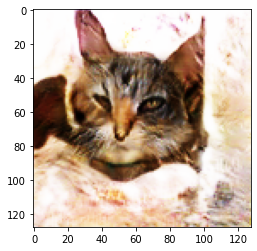

In [ ]:
generate_image(img_size=128)